## Convective/Stratiform Separation Masking for derived 3D dBZ of WRF Simulations. 

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20211006**

In [70]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [73]:
import sys
from shutil import copyfile
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
from scipy.interpolate import interpn
import xarray as xr
import pandas as pd
import wrf
from wrf import (getvar, vinterp, interplevel, extract_times, destagger, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import matplotlib as mpl
import matplotlib.pyplot as plt

import wrf_convstrat as sep0
import conv_strat_latlon as sep1
import conv_stra_sep_2 as sep2

**Set input files paths and names:**

In [67]:
def set_input_names(file_date):

    file_path_1 = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       , Z = file_path_1 
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

wrf_sim_type = 'CTRL3D'

# case_date_time = dt.datetime(2011,4,27) 
case_date_time = dt.datetime(2013,9,13) 

file_name_list = set_input_names(case_date_time)
print(file_name_list)

{'dbz': '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/CTRL3D/2013/wrf3d_d01_CTRL_dbz_20130913.nc', 'Z': '/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/2013/wrf3d_d01_CTRL_Z_20130913.nc'}


**Use wrf.interplevel directly for interpolation:**

In [68]:
# wrf_dbz = getvar(ncds_wrf_dbz, 'dBZ', meta=False)

ds_wrf_dbz = xr.open_dataset(file_name_list['dbz'])
da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=0)

data_wrf_z_unstag = wrf.destagger(getvar(Dataset(file_name_list['Z']), 'Z', timeidx=0, meta=False), 0)

interp_vertical_lev = [3000] # meter inheight.

dbz_lev = interplevel(da_wrf_dbz, data_wrf_z_unstag, interp_vertical_lev)
dbz_lev = dbz_lev.assign_attrs(vert_units='m')


**Convective/Stratiform separation:**

In [69]:
refl = np.array(dbz_lev.data)
lat = np.array(dbz_lev.XLAT)
lon = np.array(dbz_lev.XLONG)

print(type(refl))

start = time.time()

## Convective/Stratiform separation:
# cs, cc, bkgnd = sep0.conv_strat_latlon(refl, lat, lon)
cs, cc, bkgnd = sep2.conv_stra_sep(refl, lat, lon)

# cs, cc, bkgnd = sep1.conv_strat_latlon(dbz_lev.data, dbz_lev.XLAT, dbz_lev.XLONG)
# cs, cc, bkgnd = sep2.conv_stra_sep(dbz_lev.data, dbz_lev.XLAT, dbz_lev.XLONG)

end = time.time()
print("RUNTIME：%f SEC" % (end - start))
print("RUNTIME：%f MIN" % ((end - start)/60))
print("RUNTIME：%f HOUR" % ((end - start)/3600))

<class 'numpy.ndarray'>


AttributeError: module 'conv_stra_sep_2' has no attribute 'conv_stra_sep'

In [132]:
# cs

**Save interpolated field to temporary file (if needed):**

In [133]:
# dbz_lev.to_netcdf('/glade/scratch/hungjui/temp/tmp_dbz_lev.nc')
# write_xarray_to_netcdf(dbz_lev, '/glade/scratch/hungjui/temp/tmp_dbz_lev.nc')

### Test plot:

**Function: creating new map:**

In [134]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    ax.set_extent([-141, -55, 16, 61], crs=proj)
    
    ## Grab state borders:
    state_borders = NaturalEarthFeature(category='cultural', 
                                        name='admin_1_states_provinces_lines', 
                                        scale='50m', 
                                        facecolor='none'
                                       )
    ax.add_feature(state_borders, edgecolor='black', linewidth=0.8)
    
    ## Add coast lines:
    ax.coastlines('50m', 'black', linewidth=1)
    # ax.set_xticks(np.arange(-140, -50, 10))
    
    ## Add the gridlines:
    ax_gl = ax.gridlines(draw_labels=True, 
                         dms=True, 
                         x_inline=False, 
                         y_inline=False,
                         xlocs=np.arange(-140, -50, 10),
                         ylocs=np.arange(20, 70, 10),
                         color="black", 
                         linestyle="dotted")
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

**Do the plot:**

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


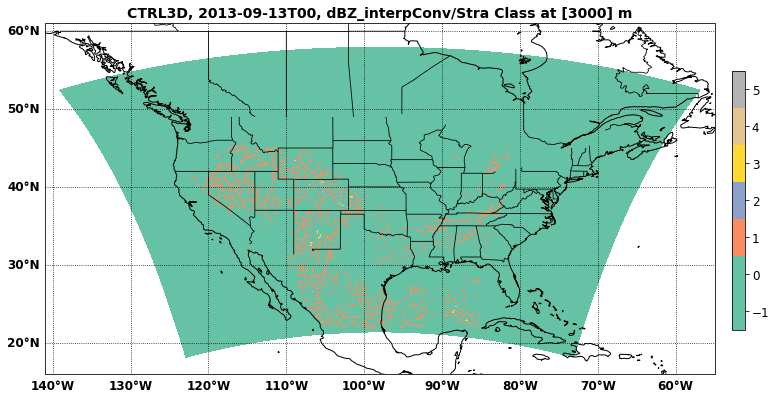

In [135]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

cs[cs<0] = np.nan
cc[cc<0] = np.nan

plotting_var = cs
plotting_lon = dbz_lev.XLONG
plotting_lat = dbz_lev.XLAT

cf1 = ax1.pcolormesh(plotting_lon, plotting_lat, plotting_var, cmap=plt.cm.get_cmap('Set2', 7))

## Title:
cf1_title = plt.title(wrf_sim_type + ', ' + 
                      np.datetime_as_string(dbz_lev.Time.data, unit='h') + ', ' + 
                      dbz_lev.name + 'Conv/Stra Class at ' + 
                      str(interp_vertical_lev) + ' ' + dbz_lev.vert_units, 
                      fontsize=14, 
                      fontweight='bold')

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, 
                    cax=cbar_ax, 
                    fraction=0.04, 
                    ticks=np.arange(-1, 6, 1), 
                    boundaries=np.arange(-1.5, 6.5, 1))
cbar.ax.tick_params(labelsize=12)
# cbar_title = plt.title('[dBZ]', fontsize=12, y=-0.1)

## Save figure:
plt.savefig('./' + np.datetime_as_string(dbz_lev.Time.data, unit='h') + '_CSmask.png', 
            bbox_inches='tight', 
            dpi=150)


In [65]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
